In [1]:
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt

import mne 

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

from corrts import *

In [2]:
fnames = eegbci.load_data(subject=1, runs=(6, 10, 14))
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in fnames])

raw.rename_channels(lambda x: x.strip("."))  # remove dots from channel names

events, _ = mne.events_from_annotations(raw, event_id=dict(T1=2, T2=3))

tmin, tmax = -1, 4
event_ids = dict(hands=2, feet=3)  # map event IDs to tasks

epochs = mne.Epochs(
    raw,
    events,
    event_ids,
    tmin - 0.5,
    tmax + 0.5,
    picks=("C3", "Cz", "C4"),
    baseline=None,
    preload=True,
)

Extracting EDF parameters from /home/jmedrano/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/jmedrano/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/jmedrano/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 961 original time points ...
0 bad epochs dropped

In [84]:
epochs.info['sfreq']

160.0

In [170]:
data = epochs.get_data()

freq = np.linspace(1,64,32) 
rg   = 0.005
Nc   = np.maximum(1, np.round(np.sqrt((2 * np.pi * freq / epochs.info['sfreq'])**2 / (2*rg))))
print(Nc)

tfr  = mne.time_frequency.tfr_array_morlet(data, epochs.info['sfreq'], freq, n_cycles=Nc, output='power')
# tfr  = np.sqrt(tfr)
tfr  = tfr[:, :, :, :2*(tfr.shape[-1] // 2)]

[ 1.  1.  2.  3.  4.  4.  5.  6.  7.  8.  8.  9. 10. 11. 12. 12. 13. 14.
 15. 16. 16. 17. 18. 19. 20. 20. 21. 22. 23. 24. 24. 25.]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


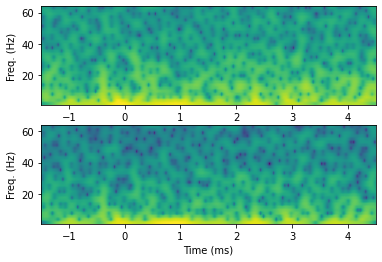

In [171]:
def plot_tfr(tfr, tvec, freq):
    extent = (tvec[0], tvec[-1], freq[0], freq[-1])
    
    plt.subplot(2,1,1)
    plt.imshow(tfr[0], aspect="auto", origin="lower", extent=extent)
    plt.xlabel('Time (ms)')
    plt.ylabel('Freq. (Hz)')
    
    plt.subplot(2,1,2)
    plt.imshow(tfr[1], aspect="auto", origin="lower", extent=extent)
    plt.xlabel('Time (ms)')
    plt.ylabel('Freq. (Hz)')
    
    
    plt.show()
    
plot_tfr(np.log(tfr[0]), epochs.times, freq)

In [190]:
fbands = dict(
    delta = (freq[0], 4), 
    theta = (4, 8), 
    alpha = (8, 13),
    beta  = (13, 30), 
    gamma = (30, freq[-1])
)

idxs = {k: np.where(np.logical_and(freq >= fmin, freq < fmax))[0]
       for k, (fmin, fmax) in fbands.items()}

pband = {k: tfr[:,:,idx].sum(2) for k, idx in idxs.items()} 
acfs  = {k: acf_welch(p) for k, p in pband.items()} 
rgs = {k: estimate_roughness(p, p) for k, p in pband.items()}


nlags = 50
for k, acf in acfs.items(): 
    
    fig = go.Figure()
    
    if k == 'delta': continue
    n = acf.shape[-1]
    acf_sums  = acf[..., 0] + np.sum(2 * np.arange(n-1, 0, -1) * acf[...,1:n] **2, -1) / n
    acf_fit   = np.exp(-  lags[None, None, :]**2 * (rgs[k][:,:, None]) / 2 )
    
    print(f'{k}:\n' 
          f'    - sum of squares:     {acf_sums.mean():.2f} ({acf_sums.std():.2f})\n'
          f'    - known, theoretical: {np.sqrt(np.pi / (2*rg)):.2f}\n'
          f'    - knwon, sum of sq.:  {np.exp(- 2* lags**2 * (rg) ).sum():.2f}\n'
          f'    - unkn., theoretical: {np.sqrt(2* np.pi/ rgs[k]).mean():.2f}\n'
          f'    - unkn., sum of sq.:  {acf_fit.sum(-1).mean():.2f} ({acf_fit.sum(-1).std():.2f})\n')
    acf_recon = np.concatenate([acf[:,:,-nlags+1:],acf[:,:,:nlags+1]], axis=-1)
    lags      = np.arange(-nlags+1, nlags+1)
#     plt.plot(lags, acf_recon**2)

    for i in range(acf.shape[0]):
        for j in range(acf.shape[1]):
            fig.add_scatter(x=lags, y=acf_recon[i,j]**2, showlegend=False, mode='lines', line_width=1, line_color='grey')
    
    fig.add_scatter(x=lags, y=acf_recon.mean((0,1))**2, showlegend=False, mode='lines', line_width=3, line_color='black')
    fig.add_scatter(x=lags, y=acf_fit.mean((0,1)), name='Gaussian fit',  showlegend=False, mode='lines', line_color='yellow', line_width=4, line_dash='dot')

    fig.add_scatter(x=lags, y=np.exp(- 2* lags**2 * (rg) ), name='Gaussian fit',  showlegend=False, mode='lines', line_color='red', line_width=4, line_dash='dash')
    fig.update_layout(template='simple_white', height=400, width=600)
    fig.show()

theta:
    - sum of squares:     18.30 (2.44)
    - known, theoretical: 17.72
    - knwon, sum of sq.:  17.72
    - unkn., theoretical: 16.90
    - unkn., sum of sq.:  16.90 (1.59)



alpha:
    - sum of squares:     19.08 (2.84)
    - known, theoretical: 17.72
    - knwon, sum of sq.:  17.72
    - unkn., theoretical: 17.53
    - unkn., sum of sq.:  17.53 (1.93)



beta:
    - sum of squares:     20.71 (3.09)
    - known, theoretical: 17.72
    - knwon, sum of sq.:  17.72
    - unkn., theoretical: 18.58
    - unkn., sum of sq.:  18.58 (1.83)



gamma:
    - sum of squares:     19.70 (3.23)
    - known, theoretical: 17.72
    - knwon, sum of sq.:  17.72
    - unkn., theoretical: 18.28
    - unkn., sum of sq.:  18.28 (2.57)



In [117]:
np.exp(- 2* lags**2 * (rg)).sum()

39.57100646760915

5.545177444479562

In [41]:
np.sqrt(2*250/np.pi)


12.6156626101008

In [11]:
lags

array([-17347, -17346, -17345, ...,  17345,  17346,  17347])

In [25]:
pearson_stats  = {k: stats_summary(pearson_r,  p[:, :, None], p[:, None, :], n_surrogates=1000) for k, p in pband.items()}
# spearman_stats = {k: stats_summary(spearman_r, p[:, 0], p[:, 1], n_surrogates=1000) for k, p in pband.items()}

/home/jmedrano/prog/python/corrts/corrts/src.py:114: RuntimeWarning: invalid value encountered in sqrt
  return 2 * scipy.stats.norm.cdf(-np.abs(z), 0, 1./np.sqrt(n-3))


In [27]:
pearson_stats['alpha']['r'].shape

(45, 3, 3)

In [32]:
pearson_stats['alpha']['r'][epochs.events[:,2] == 2].mean(0), pearson_stats['alpha']['r'][epochs.events[:,2] == 3].mean(0)

(array([[0.99895833, 0.83010949, 0.67277327],
        [0.83010949, 0.99895833, 0.81723127],
        [0.67277327, 0.81723127, 0.99895833]]),
 array([[0.99895833, 0.79961557, 0.62772304],
        [0.79961557, 0.99895833, 0.78653411],
        [0.62772304, 0.78653411, 0.99895833]]))

In [35]:
pband['alpha'].shape

(45, 3, 960)

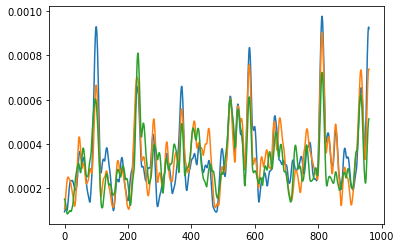

In [41]:
plt.plot(pband['beta'][3].T)